In [1]:
from google.colab import drive
drive.mount('gdrive')
%cd /content/gdrive/My\ Drive/colab

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive
/content/gdrive/My Drive/colab


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

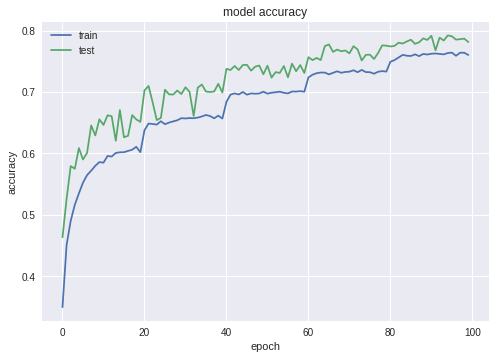

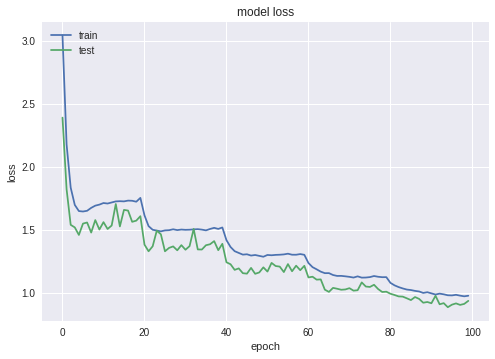

the validation 0/1 loss is:  0.8275


In [2]:
from __future__ import print_function
import json
import keras
import pickle
import os.path
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras import optimizers
from keras import regularizers
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

def build_model(x_shape, weight_decay, num_classes):
    # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
    model = Sequential()
    weight_decay = weight_decay

    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(200, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(100, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model


def normalize(X_train, X_test):
    # this function normalize inputs for zero mean and unit variance
    # it is used when training a model.
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)
    return X_train, X_test


def normalize_production(x):
    # this function is used to normalize instances in production according to saved training set statistics
    # Input: X - a training set
    # Output X - a normalized training set according to normalization constants.

    # these values produced during first training and are general for the standard cifar10 training set normalization
    mean = 120.707
    std = 64.15
    return (x - mean)/(std+1e-7)


def predict(x, normalize=True, batch_size=50):
    if normalize:
        x = normalize_production(x)
    return model.predict(x, batch_size)

def updateEpoch(epoch, logs):
  to_save = num_epoch + epoch + 1
  report_data['acc'].append(logs['acc'])
  report_data['loss'].append(logs['loss'])
  report_data['val_acc'].append(logs['val_acc'])
  report_data['val_loss'].append(logs['val_loss'])
  with open(epoch_file, "w") as file:  
    file.write(str(to_save))
  with open(data_file, "wb") as file:
    pickle.dump(report_data, file)
  with open(all_file, "a+") as file:
    all_data = [to_save, report_data['acc'], report_data['val_acc'],
               report_data['loss'], report_data['val_loss']]
    file.write(json.dumps(all_data))
  print(epoch, logs)

def train(model):
    # training parameters
    batch_size = 128
    maxepoches = 100
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20
    # The data, shuffled and split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train, x_test = normalize(x_train, x_test)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

    # data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # optimization details
    sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    plot_model(model, to_file='model.png')
    
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    lambdaCall = LambdaCallback(on_epoch_end=updateEpoch)
    callbacks_list = [reduce_lr,checkpoint,lambdaCall]

    # training process in a for loop with learning rate drop every 20 epoches.
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=maxepoches,
        validation_data=(x_test, y_test),
        callbacks=callbacks_list,
        verbose=1)

    model.save_weights('cifar10vgg_3.h5')
    
    # summarize history for accuracy
    plt.plot(report_data['acc'])
    plt.plot(report_data['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(report_data['loss'])
    plt.plot(report_data['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return history

num_classes = 10
weight_decay = 0.0005
x_shape = [32, 32, 3]
train_bool = True
epoch_file="hw1_3_epoch_num.txt"
data_file="hw1_3_data.txt"
filepath="hw1_3_weights.best.hdf5"
all_file="hw1_3_all.txt"

model = build_model(x_shape, weight_decay, num_classes)

num_epoch = 0
if not os.path.isfile(epoch_file):
  with open(epoch_file, "w+") as file:  
    file.write(str(num_epoch))
else:
  with open(epoch_file, "r") as file:  
    num_epoch = int(file.read())

if os.path.isfile(filepath):
  model.load_weights(filepath)

if os.path.isfile(data_file):
  with open(data_file, "rb") as file:
    report_data = pickle.load(file)

# print the model summary
model.summary()

report_data = {
    "acc":[],
    "val_acc":[],
    "loss":[],
    "val_loss":[]
}

if train_bool:
    history = train(model)
else:
    model.load_weights('cifar10vgg_3.h5')

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

predicted_x = model.predict(x_test)
residuals = np.argmax(predicted_x, 1) != np.argmax(y_test, 1)

loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ", loss)